In [2]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [3]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


In [4]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)


In [5]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [6]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)


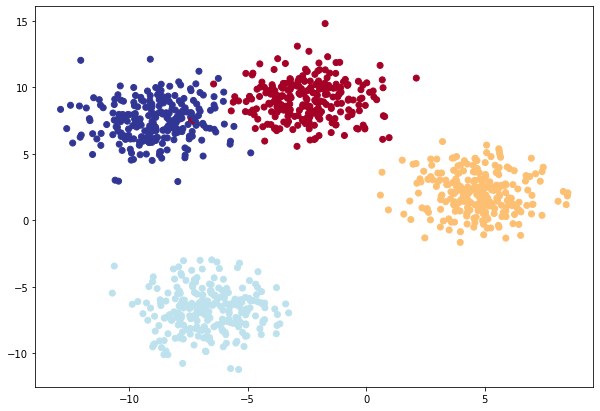

In [7]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [8]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [11]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.01) 

In [12]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]


tensor([[-0.8664, -0.9632,  0.2812, -0.2451],
        [-1.2793, -1.3733, -1.2165, -1.6611],
        [ 1.6379,  2.1098,  0.2041,  0.3914],
        [ 0.8541,  1.1651, -0.0383, -0.0392],
        [-0.9177, -0.9417, -1.0379, -1.4045]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [14]:
# How many elements in a single prediction sample
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [15]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[-1.0081, -1.1259,  0.1116, -0.4321],
        [-0.5984, -0.5214, -1.4944, -1.7111],
        [ 1.3427,  1.7413,  0.3116,  0.4017],
        [-0.4918, -0.5101,  0.3722, -0.0610],
        [-1.5133, -1.6723, -1.0236, -1.5594]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1485, 0.1320, 0.4552, 0.2642],
        [0.3550, 0.3834, 0.1449, 0.1167],
        [0.3090, 0.4603, 0.1102, 0.1206],
        [0.1697, 0.1666, 0.4026, 0.2611],
        [0.2252, 0.1921, 0.3675, 0.2151]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [16]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [18]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc


In [19]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.92802, Acc: 9.88% | Test Loss: 1.68912, Test Acc: 21.50%
Epoch: 10 | Loss: 0.76599, Acc: 88.88% | Test Loss: 0.70777, Test Acc: 94.50%
Epoch: 20 | Loss: 0.51954, Acc: 97.00% | Test Loss: 0.49089, Test Acc: 98.50%
Epoch: 30 | Loss: 0.40286, Acc: 98.12% | Test Loss: 0.38568, Test Acc: 99.50%
Epoch: 40 | Loss: 0.33033, Acc: 98.50% | Test Loss: 0.31903, Test Acc: 99.50%
Epoch: 50 | Loss: 0.27989, Acc: 98.75% | Test Loss: 0.27196, Test Acc: 99.50%
Epoch: 60 | Loss: 0.24267, Acc: 98.75% | Test Loss: 0.23674, Test Acc: 99.00%
Epoch: 70 | Loss: 0.21411, Acc: 99.00% | Test Loss: 0.20939, Test Acc: 99.00%
Epoch: 80 | Loss: 0.19156, Acc: 99.12% | Test Loss: 0.18754, Test Acc: 99.00%
Epoch: 90 | Loss: 0.17335, Acc: 99.25% | Test Loss: 0.16970, Test Acc: 99.00%


In [20]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]


tensor([[ 2.2390,  3.6259, -2.8309, -1.7967],
        [-0.6999, -6.3167, -3.5123,  0.9913],
        [-3.8424, -3.5033,  5.6706,  1.4918],
        [ 1.1514,  3.2088, -0.6782, -1.3669],
        [ 2.2949, -0.6336, -6.0977, -1.0289],
        [-0.9479, -7.7649, -4.0188,  1.3390],
        [-3.5095, -2.0104,  6.0180,  1.1083],
        [ 1.4507, -2.0753, -5.2507, -0.4890],
        [-4.5773, -5.7847,  5.6512,  2.1511],
        [ 1.7241, -1.5086, -5.4514, -0.6823]], device='cuda:0')

In [21]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.0%


In [24]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

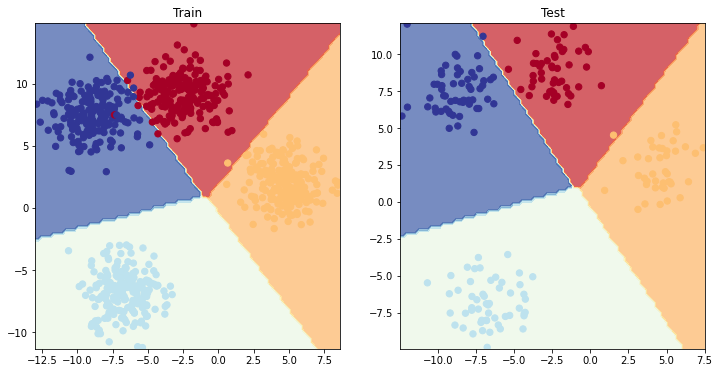

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


In [26]:
!pip -q install torchmetrics

from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 11.6 MB/s eta 0:00:00


tensor(0.9900, device='cuda:0')